In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.model_selection import KFold, train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from datetime import datetime
import os

Using TensorFlow backend.


In [35]:
PATTERNS_PATH = './patterns'
NORMALIZED_PATTERNS_PATH = './patterns/normalized'
MODEL_FILE = 'ew_final_2.h5'

BULL_STR = 'bull'
BEAR_STR = 'bear'
PATTERN_NAME_SEPARATOR = '__'
DEFAULT_NORMALIZED_SIZE = (50, 50)
FIBOS = [21, 34, 55, 89, 144, 233, 377]
PATTERN_CLASSES = [
    'flat_bear', 'flat_bull', 'impulse_bear', 'impulse_bull',
    'sideway_bear', 'sideway_bull', 'zigzag_bear', 'zigzag_bull']
# PATTERN_CLASSES = [
#     'diagonal_bear', 'diagonal_bull', 'flat_bear', 'flat_bull', 'impulse_bear', 'impulse_bull',
#     'sideway_bear', 'sideway_bull', 'triangle_bear', 'triangle_bull', 'zigzag_bear', 'zigzag_bull']

In [3]:
# import re

# regex = re.compile('[0-9]{3}|[0-9]{2}')
# files = os.listdir('./patterns')
# i = 1
# for f in files:
#     if os.path.isfile('./patterns/{}'.format(f)):
#         counter = '%06d' % (i)
#         new_name = regex.sub(counter, f)
#         os.rename('./patterns/{}'.format(f), './patterns/{}'.format(new_name))
#         i = i + 1
        

In [4]:
def normalize_pattern(source_file_name, dest_file_name, normalized_size=DEFAULT_NORMALIZED_SIZE, reverse_trend=True):
    img = Image.open(source_file_name)
    gs = img.convert("L")
    a = np.asarray(gs).copy()
    a[a>120] = 255
    a[a!=255] = 0
    x = Image.fromarray(a)
    normalized = x.resize(normalized_size)
    normalized.save(dest_file_name)
    if reverse_trend:
        if BULL_STR in dest_file_name:
            reverse_file_name = dest_file_name.replace(BULL_STR, BEAR_STR)
        elif BEAR_STR in dest_file_name:
            reverse_file_name = dest_file_name.replace(BEAR_STR, BULL_STR)
        else:
            ext_idx = dest_file_name.rindex('.')
            ext = dest_file_name[ext_idx:]
            reverse_file_name = dest_file_name.replace(ext, '_reversed'+ext)
        flipped = ImageOps.flip(normalized)
        flipped.save(reverse_file_name)
    return

def normalize_pattern_images(patterns_path, normalized_patterns_path,
                             normalized_pattern_size=DEFAULT_NORMALIZED_SIZE, reverse_trend=True):
    patterns = os.listdir(patterns_path)
    for p in patterns:
        try:
            source = '{}/{}'.format(patterns_path, p)
            ## pattern name must be at first of file name and separated with '__' from other parts.
            if PATTERN_NAME_SEPARATOR not in p:
                dest_p = p.replace(BEAR_STR, BEAR_STR+'_')
                dest_p = dest_p.replace(BULL_STR, BULL_STR+'_')
            dest = '{}/{}'.format(normalized_patterns_path, dest_p)
            normalize_pattern(source, dest, normalized_size=normalized_pattern_size, reverse_trend=reverse_trend)
        except IsADirectoryError as e:
            continue
    return
    
def convert_patterns_to_array(patterns_path, pattern_size=DEFAULT_NORMALIZED_SIZE):
    patterns = os.listdir(patterns_path)
    dataset = np.zeros(shape=(len(patterns), pattern_size[0], pattern_size[1]))
    labels = np.zeros(shape=(len(patterns), ))
    for k in range(len(patterns)):
        i = patterns[k].find(PATTERN_NAME_SEPARATOR)
        pattern_name = patterns[k][:i]
        labels[k] = PATTERN_CLASSES.index(pattern_name)
        file_name = '{}/{}'.format(patterns_path, patterns[k])
        dataset[k] = np.asarray(Image.open(file_name))
    return dataset, labels

def convert_df_to_normalized_chart(df, dest_file_name, normalized_size=DEFAULT_NORMALIZED_SIZE):
    size = len(df) / 40.0
    mpf.plot(df, type='ohlc_bars', savefig=dest_file_name, figsize=(size,size), axisoff=True, tight_layout=True)
    img = Image.open(dest_file_name)
    gs = img.convert("L")
    a = np.asarray(gs).copy()
    a[a>120] = 255
    a[a!=255] = 0
    x = Image.fromarray(a)
    normalized = x.resize(normalized_size)
    normalized.save(dest_file_name)
    return

# run below function to normalize patterns
# normalize_pattern_images(PATTERNS_PATH, NORMALIZED_PATTERNS_PATH,
#                          normalized_pattern_size=DEFAULT_NORMALIZED_SIZE, reverse_trend=True)

# convert_df_to_normalized_chart(df, './temp/test.png')

In [5]:
def load_dataset(test_size=0.20):
    X, y = convert_patterns_to_array(NORMALIZED_PATTERNS_PATH, pattern_size=DEFAULT_NORMALIZED_SIZE)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
    y = to_categorical(y)
    
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=test_size)
    return trainX, trainY, testX, testY

def prep_pixels(dataset):
    dataset = dataset.astype('float32')
    dataset = dataset / 255.0
    return dataset

def define_model(input_shape, n_categories):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
#     model.add(Dropout(0.30))
    model.add(Dense(150, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dropout(0.30))
#     model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_categories, activation='softmax'))
    
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(dataX, dataY, input_shape, n_categories, n_folds=5):
    scores, histories = [], []
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(dataX):
        print('> ', end='')
        model = define_model(input_shape, n_categories)
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('%.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)
    return scores, histories

def evaluate_aug_model(dataX, dataY, input_shape, n_categories, n_folds=5):
    scores, histories = [], []
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(dataX):
        print('> ', end='')
        model = define_model(input_shape, n_categories)
        aug = ImageDataGenerator(rotation_range=0, zoom_range=0.15, shear_range=0,
                                 height_shift_range=0.1, width_shift_range=0.1,
                                 horizontal_flip=False, vertical_flip=False, fill_mode="nearest")
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        history = model.fit_generator(aug.flow(trainX, trainY, batch_size=16),
                                      epochs=20, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('%.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)
    return scores, histories

def summerize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(1, 2, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # plot accuracy
        plt.subplot(1, 2, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
    return

def summerize_performance(scores):
    print('Accuracy: mean=%.3f, std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    plt.boxplot(scores)
    plt.show()
    return

def run_test_harness():
    trainX, trainY, testX, testY = load_dataset(test_size=0.20)
    trainX = prep_pixels(trainX)
    testX = prep_pixels(testX)
    scores, histories = evaluate_model(trainX, trainY, input_shape=(trainX.shape[1], trainX.shape[2], 1), n_categories=len(PATTERN_CLASSES), n_folds=5)
##     scores, histories = evaluate_aug_model(trainX, trainY, input_shape=(trainX.shape[1], trainX.shape[2], 1), n_categories=len(PATTERN_CLASSES), n_folds=5)
    summerize_diagnostics(histories)
    summerize_performance(scores)
    return

def run_test_evaluate(save_path=None):
    print('Running model ...')
    trainX, trainY, testX, testY = load_dataset(test_size=0.20)
    trainX = prep_pixels(trainX)
    testX = prep_pixels(testX)
    model = define_model(input_shape=(trainX.shape[1], trainX.shape[2], 1), n_categories=len(PATTERN_CLASSES))
    model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=0)
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('Accuracy: %.3f' % (acc * 100.0))
    if save_path:
        model.save(save_path)
    return

def recognize_wave(model, normalized_wave_file, single_class=True):
    wave_array = np.asarray(Image.open(normalized_wave_file))
    wave_array = wave_array.reshape(1, wave_array.shape[0], wave_array.shape[1], 1)
    wave_array = prep_pixels(wave_array)
    
#     model = load_model(model_path)
    if single_class:
        pattern = model.predict_classes(wave_array)
        return pattern[0]
    else:
        probs = model.predict(wave_array)
        return probs

# run_test_harness()
# run_test_evaluate(save_path=MODEL_FILE)
# probs = recognize_wave(model_path='ew_final.h5', normalized_wave_file='./temp/test.png', single_value=False)


In [30]:
model = load_model('ew_final.h5')
probs = recognize_wave(model=model, normalized_wave_file='./temp/test.png', single_class=False)
for i in range(probs.shape[1]):
    print(probs[0][i], PATTERN_CLASSES[i])
print(np.argmax(probs[0]))

0.053489424 flat_bear
0.00088140235 flat_bull
0.9318876 impulse_bear
0.00055607216 impulse_bull
0.0073242458 sideway_bear
0.0050434833 sideway_bull
0.00047010052 zigzag_bear
0.00034755722 zigzag_bull
2


In [8]:
result = dict()
for days in FIBOS:
    key = '{}-{}'.format(symbol.lower(), days)
    file_name = './temp/{}.png'.format(key)
    convert_df_to_normalized_chart(df[-days:], dest_file_name=file_name, normalized_size=DEFAULT_NORMALIZED_SIZE)
    cat_idx = recognize_wave(model_path='ew_final.h5', normalized_wave_file=file_name, single_class=True)
    result[key] = PATTERN_CLASSES[cat_idx]
print(result)

{'pg-21': 'zigzag_bear', 'pg-34': 'impulse_bull', 'pg-55': 'impulse_bull', 'pg-89': 'impulse_bull', 'pg-144': 'zigzag_bear'}


In [8]:
# def recognize_pattern_in_df_2(model, df, prob_threshold=0.95, dest_file_name=None, normalized_image_size=DEFAULT_NORMALIZED_SIZE):
#     temp_file = '~~~temp~~~.png'
#     if dest_file_name is None:
#         dest_file_name = temp_file
#     convert_df_to_normalized_chart(df, dest_file_name=dest_file_name, normalized_size=normalized_image_size)
#     cats = recognize_wave(model=model, normalized_wave_file=dest_file_name, single_class=False)
#     cat_idx = np.argmax(cats[0])
#     if cats[0][cat_idx] >= prob_threshold:
#         pattern = PATTERN_CLASSES[cat_idx]
#     else:
#         pattern = None
#     if os.path.exists(temp_file):
#         os.remove(temp_file)
#     return pattern

def recognize_pattern_in_df(model, df, prob_threshold=0.95,
                            dest_file_name=None, normalized_image_size=DEFAULT_NORMALIZED_SIZE,
                            dest_file_scale_factor=1):
    temp_file = '~~~temp~~~.png'
    convert_df_to_normalized_chart(df, dest_file_name=temp_file, normalized_size=normalized_image_size)
    cats = recognize_wave(model=model, normalized_wave_file=temp_file, single_class=False)
    cat_idx = np.argmax(cats[0])
    if cats[0][cat_idx] >= prob_threshold:
        pattern = PATTERN_CLASSES[cat_idx]
        if dest_file_name is not None:
            scaled_image_size = tuple(dest_file_scale_factor * np.array(normalized_image_size))
            convert_df_to_normalized_chart(df, dest_file_name=dest_file_name, normalized_size=scaled_image_size)
    else:
        pattern = None
    if os.path.exists(temp_file):
        os.remove(temp_file)
    return pattern

def fetch_waves_from_df(model, df, dest_path, prob_threshold=0.95, window_size=144, slide_size=10,
                        symbol='', image_size=DEFAULT_NORMALIZED_SIZE, image_scale_factor=1):
    start_idx, end_idx, counter = 0, window_size, 1
    while start_idx < len(df):
        file_name = '{}/{}_{:03d}.png'.format(dest_path, symbol.lower(), counter)
        pattern = recognize_pattern_in_df(model, df[start_idx:end_idx], prob_threshold=prob_threshold,
                                          dest_file_name=file_name, normalized_image_size=image_size,
                                          dest_file_scale_factor=image_scale_factor)
        if pattern:
            new_file_name = '{}/{}__{}_{}_{:03d}.png'.format(dest_path, pattern, symbol.lower(), window_size, counter)
            os.rename(file_name, new_file_name)
            print('o', end='')
        else:
            if os.path.exists(file_name):
                os.remove(file_name)
            print('x', end='')
        start_idx, end_idx, counter = start_idx + slide_size, end_idx + slide_size, counter + 1
    return

# symbol = 'AVY' #'PG'
# # df = web.DataReader(symbol, data_source='yahoo')
# if 'model' in locals():
#     model = None
# model = load_model(MODEL_FILE)
# fetch_waves_from_df(model, df, './temp', prob_threshold=0.99, window_size=34, slide_size=2,
#                     symbol=symbol, image_size=DEFAULT_NORMALIZED_SIZE, image_scale_factor=2)
# pattern = recognize_pattern_in_df(model, df[:300])
# print(pattern)

Searching pattern in last 21 days ...
Searching pattern in last 34 days ...
Searching pattern in last 55 days ...
Searching pattern in last 89 days ...
Searching pattern in last 144 days ...
Searching pattern in last 233 days ...
Searching pattern in last 377 days ...


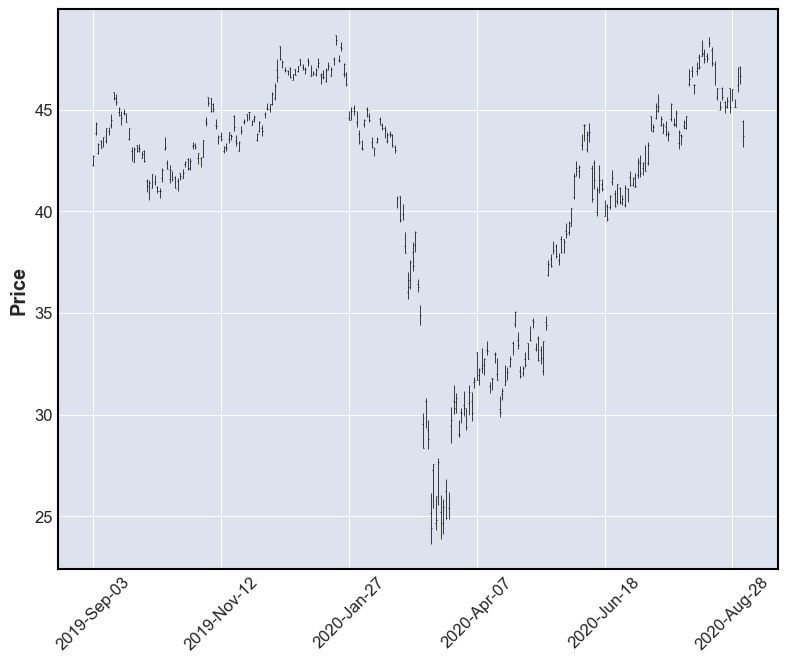

In [41]:
symbol = 'BBL' #'WMT' #'PG' #'BTC-USD' #'GOOG' #'NOK' #'TSLA'
end = datetime.now().date()
y = end.year - 1
start = datetime(y, end.month, end.day).date()
df = web.DataReader(symbol, data_source='yahoo', start=start, end=end)

if 'model' in locals():
    model = None
model = load_model(MODEL_FILE)

# fibos = [34]
## df must be in ascending order on date
for fib in FIBOS:
    print('Searching pattern in last {} days ...'.format(fib))
    dest_file_name = './temp/{}_{}.png'.format(symbol, fib)
    pattern = recognize_pattern_in_df(model, df[-fib:], prob_threshold=0.90, dest_file_name=dest_file_name,
                                      normalized_image_size=DEFAULT_NORMALIZED_SIZE,
                                      dest_file_scale_factor=2)
    if pattern:
        new_file_name = './temp/{}__{}_{}.png'.format(pattern, symbol, fib)
        os.rename(dest_file_name, new_file_name)
        
mpf.plot(df, type='ohlc_bars', figsize=(10,8))


In [18]:
print("\u2713")

✓
